In [69]:
import glob, os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import defaultdict

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float64)

In [17]:
'''
observed jaw kinematics : Iθ¨(t) + bθ˙(t) + kθ(t)  - torque = 0
I = inertia, b= damping, k = stiffness
learned articulatory embedding : z=fCNN​(θ,x,y)
input = ( t ), embeddings
output = a(t), (b,k,f_max)
constant : I = jaw intertia
            Moment arm = r
torque model = τ = sin(2pit).f_max (simplified)
loss function: l_contrastive + l_kinetics + l_regularization
'''

'\nobserved jaw kinematics : Iθ¨(t) + bθ˙(t) + kθ(t)  - torque = 0\nI = inertia, b= damping, k = stiffness\nlearned articulatory embedding : z=fCNN\u200b(θ,x,y)\ninput = ( t ), embeddings\noutput = a(t), (b,k,f_max)\nconstant : I = jaw intertia\n            Moment arm = r\ntorque model = τ = sin(2pit).f_max (simplified)\nloss function: l_contrastive + l_kinetics + l_regularization\n'

In [71]:
src_pattern = r'/workspace/Krrish/Silent_Speech/dataset_sony/Normalized_dataset/recordings/*/*.csv'
files = glob.glob(src_pattern)

T = 150
features = ["theta"]

theta_chunks = []
word_labels = []

for fp in files:
    df = pd.read_csv(fp)
    theta = df["theta"].values

    n_chunks = len(theta) // T
    if n_chunks == 0:
        continue

    theta = theta[:n_chunks*T].reshape(n_chunks, T)
    theta_chunks.append(theta)

    word = os.path.basename(os.path.dirname(fp))
    word_labels.extend([word] * n_chunks)

theta_all = np.vstack(theta_chunks)     # (N_chunks, T)
word_labels = np.array(word_labels)


In [72]:
unique_words = sorted(set(word_labels))
word2id = {w: i for i, w in enumerate(unique_words)}
id2word = {i: w for w, i in word2id.items()}


In [73]:
theta_dict = {}

for w_name, w_id in word2id.items():
    idxs = np.where(word_labels == w_name)[0]
    theta_mean = theta_all[idxs].mean(axis=0)   # (T,)

    theta_dict[w_id] = torch.tensor(
        theta_mean,
        dtype=torch.float64,
        device=device
    ).unsqueeze(-1)                             # (T,1)


In [74]:
print(len(theta_dict))        # 25
print(theta_dict[0].shape)   # (T,1)


25
torch.Size([150, 1])


In [75]:
t = torch.linspace(0.0, 1.0, T, device=device).unsqueeze(-1)
t.requires_grad_(True)

tensor([[0.0000],
        [0.0067],
        [0.0134],
        [0.0201],
        [0.0268],
        [0.0336],
        [0.0403],
        [0.0470],
        [0.0537],
        [0.0604],
        [0.0671],
        [0.0738],
        [0.0805],
        [0.0872],
        [0.0940],
        [0.1007],
        [0.1074],
        [0.1141],
        [0.1208],
        [0.1275],
        [0.1342],
        [0.1409],
        [0.1477],
        [0.1544],
        [0.1611],
        [0.1678],
        [0.1745],
        [0.1812],
        [0.1879],
        [0.1946],
        [0.2013],
        [0.2081],
        [0.2148],
        [0.2215],
        [0.2282],
        [0.2349],
        [0.2416],
        [0.2483],
        [0.2550],
        [0.2617],
        [0.2685],
        [0.2752],
        [0.2819],
        [0.2886],
        [0.2953],
        [0.3020],
        [0.3087],
        [0.3154],
        [0.3221],
        [0.3289],
        [0.3356],
        [0.3423],
        [0.3490],
        [0.3557],
        [0.3624],
        [0

In [76]:
data = np.load(r'/workspace/Krrish/Silent_Speech/src/feature_extraction/z_word_embeddings.npz')
word_ids = data["word_ids"]        # length = 25
embeddings = data["embeddings"]    # (25, 56)

embeddings_torch = torch.tensor(embeddings, device=device)

embed_time_dict = {}

for i in range(len(word_ids)):
    w_id = int(word_ids[i])

    e_w = embeddings_torch[i]                  # (56,)
    e_w_time = e_w.unsqueeze(0).repeat(T, 1)   # (T,56)

    pinn_input = torch.cat([t, e_w_time], dim=1)  # (T,57)
    embed_time_dict[w_id] = pinn_input


In [77]:
class DuffingSpeechPINN(nn.Module):
    def __init__(self, in_dim=65, hidden_dim=128):
        super().__init__()
        
        # A. Trajectory Net (The Motion)
        # Input: [Time (1) + Embeddings (64)]
        self.theta_net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1) # Output: theta(t)
        )

        # B. Force Net (The Driver)
        # Input: [Time (1) + Embeddings (64)]
        self.force_net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(), # Swish activation (smooth, non-monotonic) ideal for forces
            nn.Linear(hidden_dim, 1) # Output: Force(t)
        )

        # C. Global Physics Parameters (The Hardware)
        # Initialized to reasonable physical values
        self.b = nn.Parameter(torch.tensor(0.5))   # Damping
        self.k1 = nn.Parameter(torch.tensor(2.0))  # Linear Stiffness
        self.k2 = nn.Parameter(torch.tensor(0.1))  # Cubic Stiffness (Duffing)

    def forward(self, x):
        # x is concatenated [t, embeddings]
        theta = self.theta_net(x)
        force = self.force_net(x)
        return theta, force

In [78]:
def compute_duffing_loss(model, inputs, theta_true, lambda_phys=0.1):
    # inputs: [Batch, Time+Embed]
    # We need t specifically for gradients. 
    # Assuming inputs[:, 0] is time 't'
    
    # We need to clone inputs to allow gradient computation w.r.t time
    inputs.requires_grad_(True)
    t = inputs[:, 0:1] # Extract time column
    
    # 1. Forward Pass
    theta_pred, force_pred = model(inputs)
    
    # 2. Compute Derivatives (Automatic Differentiation)
    # d(theta)/dt
    grad_1 = torch.autograd.grad(
        theta_pred, inputs, 
        grad_outputs=torch.ones_like(theta_pred), 
        create_graph=True
    )[0]
    velocity = grad_1[:, 0:1] # Only take gradient w.r.t time (first col)
    
    # d^2(theta)/dt^2
    grad_2 = torch.autograd.grad(
        velocity, inputs, 
        grad_outputs=torch.ones_like(velocity), 
        create_graph=True
    )[0]
    acceleration = grad_2[:, 0:1]
    
    # 3. Get Physical Parameters (Enforce Positivity)
    b = torch.nn.functional.softplus(model.b)
    k1 = torch.nn.functional.softplus(model.k1)
    k2 = torch.nn.functional.softplus(model.k2)
    
    # 4. The Duffing Equation Residual
    # Equation: acc + b*vel + k1*pos + k2*pos^3 - Force = 0
    physics_residual = (
        acceleration + 
        (b * velocity) + 
        (k1 * theta_pred) + 
        (k2 * theta_pred**3) - 
        force_pred
    )
    
    # 5. Calculate Losses
    loss_data = torch.mean((theta_pred - theta_true)**2)
    loss_physics = torch.mean(physics_residual**2)
    
    # Regularization to keep force magnitude realistic
    loss_force_reg = torch.mean(force_pred**2) * 1e-4
    
    total_loss = loss_data + (lambda_phys * loss_physics) + loss_force_reg
    
    return total_loss, {
        "loss": total_loss.item(),
        "data": loss_data.item(),
        "physics": loss_physics.item(),
        "b": b.item(),
        "k1": k1.item(),
        "k2": k2.item()
    }

In [81]:
class SpeechDataset():
    def __init__(self, theta_dict, embed_time_dict):
        self.samples = []
        for word in theta_dict.keys():
            # inputs: [Time, 1+Embed]
            inputs = embed_time_dict[word] 
            # targets: [Time, 1]
            targets = theta_dict[word]
            
            # We flatten the time series into individual training points
            # or keep them as sequences. Flattening is often easier for PINNs.
            if isinstance(inputs, torch.Tensor):
                inputs = inputs.float()
                targets = targets.float()
                
                # Add to list
                for i in range(len(inputs)):
                    self.samples.append((inputs[i], targets[i], word))
                    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [82]:
dataset = SpeechDataset(theta_dict, embed_time_dict)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

# B. Initialize Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DuffingSpeechPINN(in_dim=65).to(device) # 1 time + 64 emb
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# C. Training Loop
num_epochs = 200 # Increase for better convergence
print(f"Training on {len(dataset)} points...")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_inputs, batch_targets, _ in dataloader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        
        optimizer.zero_grad()
        
        loss, logs = compute_duffing_loss(model, batch_inputs, batch_targets)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {logs['loss']:.5f} | "
              f"Data: {logs['data']:.5f} | Phys: {logs['physics']:.5f} | "
              f"b: {logs['b']:.2f}, k1: {logs['k1']:.2f}, k2: {logs['k2']:.2f}")

# ==========================================
# 5. Extract Results & Visualize
# ==========================================
results = {}
model.eval()

# We run one pass over words to generate the final trajectories
for w in theta_dict.keys():
    inputs = embed_time_dict[w].to(device)
    inputs.requires_grad_(True) # Needed for physics check
    
    # Forward
    theta_hat, force_hat = model(inputs)
    
    # Calculate Residual for analysis
    # (Re-run physics calc logic for just this word)
    t = inputs[:, 0:1]
    g1 = torch.autograd.grad(theta_hat, inputs, torch.ones_like(theta_hat), create_graph=True)[0]
    vel = g1[:, 0:1]
    g2 = torch.autograd.grad(vel, inputs, torch.ones_like(vel), create_graph=True)[0]
    acc = g2[:, 0:1]
    
    b = torch.nn.functional.softplus(model.b)
    k1 = torch.nn.functional.softplus(model.k1)
    k2 = torch.nn.functional.softplus(model.k2)
    
    residual = (acc + b*vel + k1*theta_hat + k2*theta_hat**3 - force_hat)
    
    results[w] = {
        "theta_hat": theta_hat.detach(),
        "force_hat": force_hat.detach(),
        "residual": residual.detach(),
        "theta_true": theta_dict[w].detach()
    }

NameError: name 'DataLoader' is not defined

In [ ]:
for w, r in results.items():
    print(f"{w:>10} → b={r['b']:.3f}, k={r['k']:.3f}, fmax={r['fmax']:.3f}")


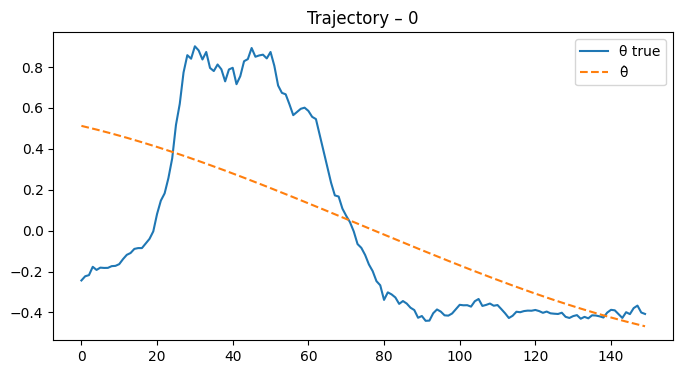

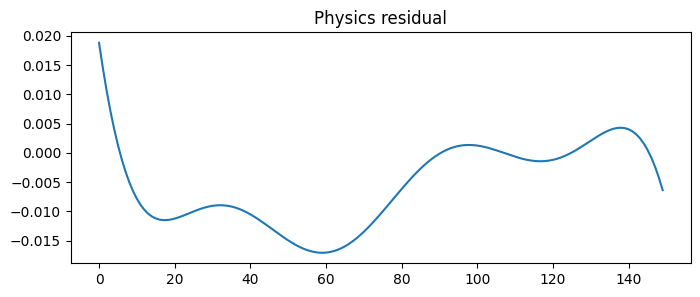

In [30]:
w_example = list(results.keys())[0]
data = results[w_example]

plt.figure(figsize=(10, 8))

# Plot 1: Trajectory
plt.subplot(3, 1, 1)
plt.plot(data["theta_true"].cpu(), label="True Jaw Angle", color='black', alpha=0.6)
plt.plot(data["theta_hat"].cpu(), label="PINN Prediction", color='blue', linestyle='--')
plt.title(f"Reconstruction: {w_example}")
plt.legend()

# Plot 2: The Learned Force (The Driver)
plt.subplot(3, 1, 2)
plt.plot(data["force_hat"].cpu(), color='red')
plt.title("Learned Latent Force F(t) (Motor Command)")
plt.grid(True, alpha=0.3)

# Plot 3: Physics Residual (Anomaly)
plt.subplot(3, 1, 3)
plt.plot(data["residual"].cpu(), color='green')
plt.title("Physics Residual (Unexplained Dynamics)")
plt.tight_layout()
plt.show()

print(f"Final Global Parameters -> b: {b.item():.4f}, k1: {k1.item():.4f}, k2: {k2.item():.4f}")

In [31]:
src_pattern = r'/workspace/Krrish/Silent_Speech/dataset_sony/Normalized_dataset/recordings/*/*.csv'
files = glob.glob(src_pattern)

T = 150

theta_chunks = []
x_chunks = []
y_chunks = []
word_ids = []   # numeric word IDs per chunk

# build word → id mapping once
word_names = sorted({os.path.basename(os.path.dirname(fp)) for fp in files})
word2id = {w: i for i, w in enumerate(word_names)}
id2word = {i: w for w, i in word2id.items()}

for fp in files:
    df = pd.read_csv(fp)

    theta = df["theta"].values
    x = df["x"].values
    y = df["y"].values

    n_chunks = len(theta) // T
    if n_chunks == 0:
        continue

    theta = theta[:n_chunks*T].reshape(n_chunks, T)
    x     = x[:n_chunks*T].reshape(n_chunks, T)
    y     = y[:n_chunks*T].reshape(n_chunks, T)

    theta_chunks.append(theta)
    x_chunks.append(x)
    y_chunks.append(y)

    w_name = os.path.basename(os.path.dirname(fp))
    w_id = word2id[w_name]

    word_ids.extend([w_id] * n_chunks)

theta_all = np.vstack(theta_chunks)   # (N_chunks, T)
x_all     = np.vstack(x_chunks)
y_all     = np.vstack(y_chunks)
word_ids  = np.array(word_ids)

In [32]:
import torch

theta_dict = {}
x_dict = {}
y_dict = {}

for w_id in np.unique(word_ids):
    idxs = np.where(word_ids == w_id)[0]

    theta_mean = theta_all[idxs].mean(axis=0)  # (T,)
    x_mean     = x_all[idxs].mean(axis=0)
    y_mean     = y_all[idxs].mean(axis=0)

    theta_dict[w_id] = torch.tensor(
        theta_mean, dtype=torch.float64, device=device
    ).unsqueeze(-1)  # (T,1)

    x_dict[w_id] = torch.tensor(
        x_mean, dtype=torch.float64, device=device
    ).unsqueeze(-1)

    y_dict[w_id] = torch.tensor(
        y_mean, dtype=torch.float64, device=device
    ).unsqueeze(-1)


In [33]:
print(len(theta_dict), len(x_dict), len(y_dict))  # all should be 25

w = 0
print(theta_dict[w].shape)  # (150,1)
print(x_dict[w].shape)
print(y_dict[w].shape)


25 25 25
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])


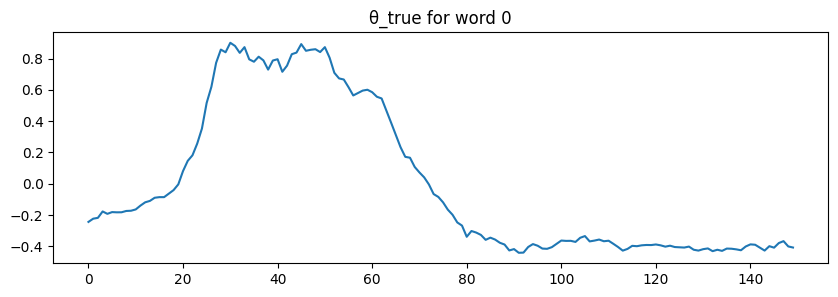

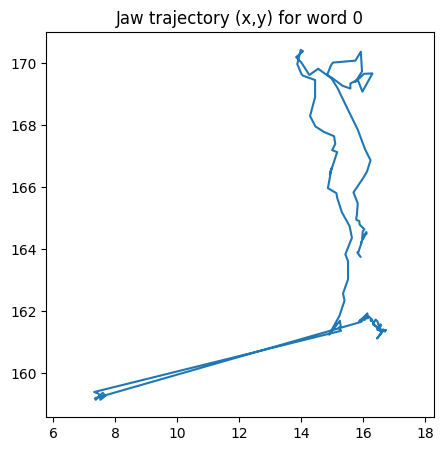

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
plt.plot(theta_dict[w].cpu())
plt.title(f"θ_true for word {w}")
plt.show()

plt.figure(figsize=(5,5))
plt.plot(x_dict[w].cpu(), y_dict[w].cpu())
plt.title(f"Jaw trajectory (x,y) for word {w}")
plt.axis("equal")
plt.show()


In [35]:
def compute_word_features(
    theta,        # (T,1)
    omega,        # (T,1)
    x, y,         # (T,1)
    t,            # (T,1)
    b, k, fmax,
    eps=1e-6
):
    """
    Returns: np.array of shape (11,)
    """

    # ---- detach + flatten ----
    theta = theta.detach().squeeze().cpu().numpy()
    omega = omega.detach().squeeze().cpu().numpy()
    x     = x.detach().squeeze().cpu().numpy()
    y     = y.detach().squeeze().cpu().numpy()
    t     = t.detach().squeeze().cpu().numpy()

    # ---- angular features ----
    dtheta   = theta.max() - theta.min()
    theta_pk = theta.max()
    t_pk     = t[np.argmax(theta)]
    energy   = np.mean(omega**2)

    # ---- spatial features ----
    dx = x.max() - x.min()
    dy = y.max() - y.min()

    # path length
    dx_i = np.diff(x)
    dy_i = np.diff(y)
    L = np.sum(np.sqrt(dx_i**2 + dy_i**2))

    # curvature
    x1 = np.gradient(x)
    y1 = np.gradient(y)
    x2 = np.gradient(x1)
    y2 = np.gradient(y1)

    curvature = np.abs(x1*y2 - y1*x2) / ((x1**2 + y1**2)**1.5 + eps)
    kappa_bar = np.mean(curvature)

    return np.array([
        b, k, fmax,
        dx, dy, L, kappa_bar,
        dtheta, theta_pk, t_pk, energy
    ])


In [36]:
feature_dict = {}

for w_id in results.keys():

    phi_w = compute_word_features(
        theta = results[w_id]["theta_true"],
        omega = omega_hat,  # or recompute from theta_hat
        x     = x_dict[w_id],
        y     = y_dict[w_id],
        t     = t,
        b     = results[w_id]["b"],
        k     = results[w_id]["k"],
        fmax  = results[w_id]["fmax"]
    )

    feature_dict[w_id] = phi_w

In [37]:
print(len(feature_dict))          # should be 25
print(feature_dict[0].shape)     # (11,)
X = np.vstack(list(feature_dict.values()))

print("min:", X.min(axis=0))
print("max:", X.max(axis=0))


25
(11,)
min: [ 0.05261576  2.40051006  0.08652809  1.6741573   3.44186047 15.81932631
  4.2235878   1.05343202  0.71501958  0.17449664  0.94825781]
max: [  0.55821485   4.68734739   0.2209595   10.96202532  13.4556962
 152.55330076  72.43048707   2.05567191   1.42268071   0.44966443
   0.94825781]


In [38]:
import numpy as np

# feature_dict: {word_id: (11,)}

word_ids = sorted(feature_dict.keys())

X = np.vstack([feature_dict[w] for w in word_ids])   # (25, 11)
y = np.array(word_ids)                               # (25,)

print("X shape:", X.shape)


X shape: (25, 11)


In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)


In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())


Explained variance ratio: [0.3797553  0.28363682]
Total explained variance: 0.6633921179741639


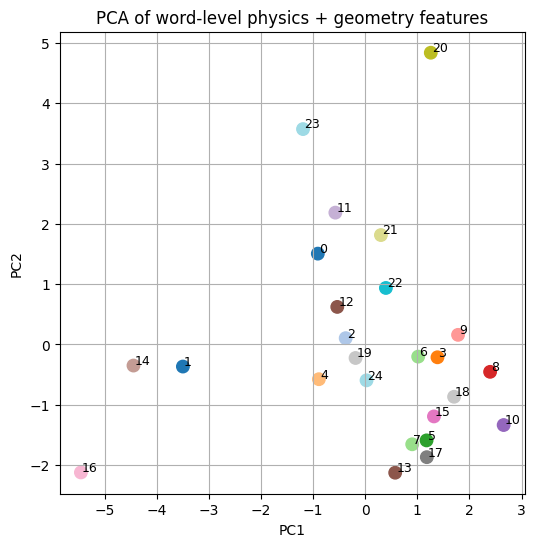

In [41]:
plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="tab20", s=80)

for i, w in enumerate(y):
    plt.text(X_pca[i,0]+0.02, X_pca[i,1]+0.02, str(w), fontsize=9)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of word-level physics + geometry features")
plt.grid(True)
plt.show()


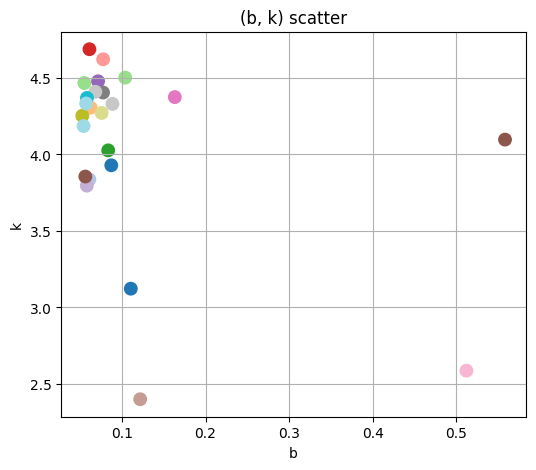

In [42]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap="tab20", s=80)
plt.xlabel("b")
plt.ylabel("k")
plt.title("(b, k) scatter")
plt.grid(True)
plt.show()


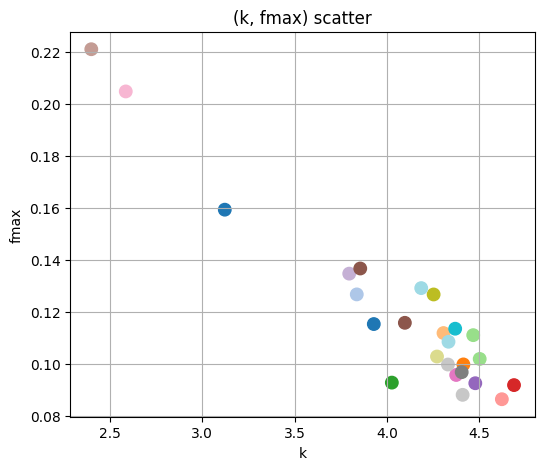

In [43]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,1], X[:,2], c=y, cmap="tab20", s=80)
plt.xlabel("k")
plt.ylabel("fmax")
plt.title("(k, fmax) scatter")
plt.grid(True)
plt.show()


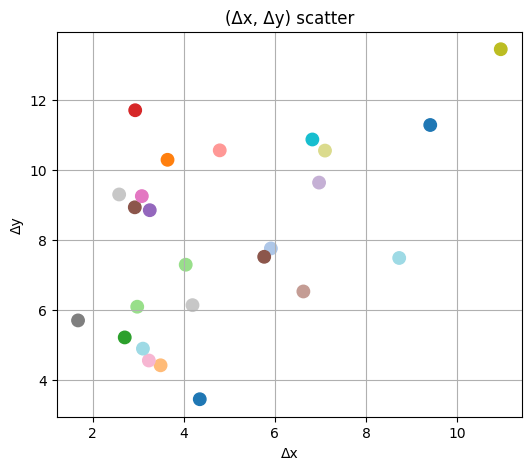

In [44]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,3], X[:,4], c=y, cmap="tab20", s=80)
plt.xlabel("Δx")
plt.ylabel("Δy")
plt.title("(Δx, Δy) scatter")
plt.grid(True)
plt.show()


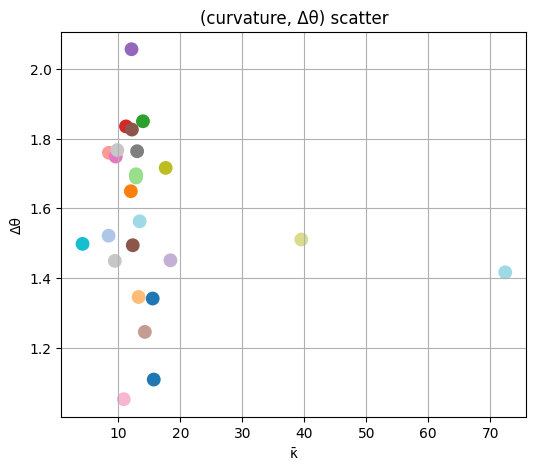

In [45]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,6], X[:,7], c=y, cmap="tab20", s=80)
plt.xlabel("κ̄")
plt.ylabel("Δθ")
plt.title("(curvature, Δθ) scatter")
plt.grid(True)
plt.show()


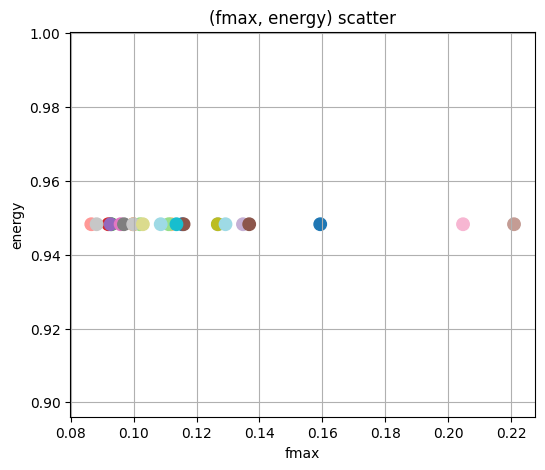

In [46]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,2], X[:,10], c=y, cmap="tab20", s=80)
plt.xlabel("fmax")
plt.ylabel("energy")
plt.title("(fmax, energy) scatter")
plt.grid(True)
plt.show()


In [47]:
from sklearn.metrics import pairwise_distances

D = pairwise_distances(X_std)
print("Mean inter-word distance:", D.mean())
print("Min non-zero distance:", D[D > 0].min())


Mean inter-word distance: 3.9973107055638675
Min non-zero distance: 0.8467195059961066


In [48]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

clf = SVC(kernel="linear", C=1.0)
clf.fit(X_std, y)

y_pred = clf.predict(X_std)

acc = accuracy_score(y, y_pred)
print("Training accuracy:", acc)


Training accuracy: 1.0


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:755: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)


In [49]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_std, y)

y_pred_knn = knn.predict(X_std)
print("k-NN accuracy:", accuracy_score(y, y_pred_knn))


k-NN accuracy: 0.32


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_base.py:501: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)


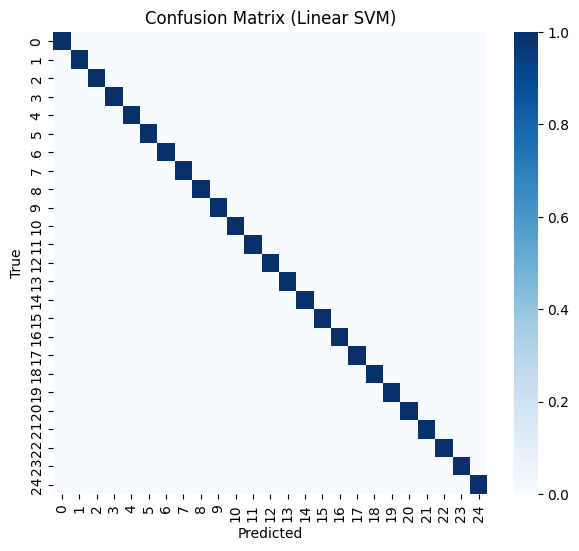

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Linear SVM)")
plt.show()


In [51]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [52]:
src_pattern = "/workspace/Krrish/Silent_Speech/dataset_sony/Normalized_dataset/recordings/*/*.csv"
files = glob.glob(src_pattern)

word_names = sorted({os.path.basename(os.path.dirname(fp)) for fp in files})
word2id = {w: i for i, w in enumerate(word_names)}
id2word = {i: w for w, i in word2id.items()}

speaker_names = sorted({os.path.basename(fp).replace(".csv", "") for fp in files})
speaker2id = {s: i for i, s in enumerate(speaker_names)}


In [53]:
from scipy.interpolate import interp1d

def resample_to_T(arr, T):
    x_old = np.linspace(0, 1, len(arr))
    x_new = np.linspace(0, 1, T)
    f = interp1d(x_old, arr, kind="linear", fill_value="extrapolate")
    return f(x_new)

def load_utterance(fp, T=150):
    df = pd.read_csv(fp)

    theta = df["theta"].values
    x = df["x"].values
    y = df["y"].values
    t = df["t"].values

    if len(theta) < 10:   # safety check only
        return None

    theta = resample_to_T(theta, T)
    x     = resample_to_T(x, T)
    y     = resample_to_T(y, T)
    t     = np.linspace(0, 1, T)

    return theta, x, y, t


In [54]:
def make_pinn_input(word_id, t, embeddings_torch):
    t = torch.tensor(t, dtype=torch.float64, device=device).unsqueeze(-1)
    t.requires_grad_(True)

    e = embeddings_torch[word_id]             # (D,)
    e_time = e.unsqueeze(0).repeat(len(t), 1)

    pinn_input = torch.cat([t, e_time], dim=1)
    return pinn_input, t


In [55]:
def compute_features(theta, omega, x, y, t, b, k, fmax, eps=1e-6):
    theta = theta.detach().cpu().numpy().squeeze()
    omega = omega.detach().cpu().numpy().squeeze()
    x = x.detach().cpu().numpy().squeeze()
    y = y.detach().cpu().numpy().squeeze()
    t = t.detach().cpu().numpy().squeeze()

    dtheta = theta.max() - theta.min()
    theta_peak = theta.max()
    t_peak = t[np.argmax(theta)]
    energy = np.mean(omega**2)

    dx = x.max() - x.min()
    dy = y.max() - y.min()

    dx_i = np.diff(x)
    dy_i = np.diff(y)
    L = np.sum(np.sqrt(dx_i**2 + dy_i**2))

    x1 = np.gradient(x)
    y1 = np.gradient(y)
    x2 = np.gradient(x1)
    y2 = np.gradient(y1)
    kappa = np.abs(x1*y2 - y1*x2) / ((x1**2 + y1**2)**1.5 + eps)
    kappa_bar = np.mean(kappa)

    return np.array([
        b, k, fmax,
        dx, dy, L, kappa_bar,
        dtheta, theta_peak, t_peak, energy
    ])


In [56]:
word_params = {}

for w_id in results.keys():
    word_params[w_id] = {
        "b": results[w_id]["b"],
        "k": results[w_id]["k"],
        "fmax": results[w_id]["fmax"]
    }

print("Number of words with params:", len(word_params))
print("Example word params:", word_params[list(word_params.keys())[0]])


Number of words with params: 25
Example word params: {'b': 0.08727527876721662, 'k': 3.9288335044817084, 'fmax': 0.11540133356881281}


In [57]:
X_utt = []
y_word = []
y_speaker = []

for fp in files:
    out = load_utterance(fp, T)
    if out is None:
        continue

    theta_np, x_np, y_np, t_np = out

    word_name = os.path.basename(os.path.dirname(fp))
    speaker_name = os.path.basename(fp).replace(".csv", "")

    w_id = word2id[word_name]
    s_id = speaker2id[speaker_name]

    pinn_input, t = make_pinn_input(w_id, t_np, embeddings_torch)

    theta_true = torch.tensor(
        theta_np, dtype=torch.float64, device=device
    ).unsqueeze(-1)

    # ---- TRAIN PINN (YOUR EXISTING FUNCTION) ----
    b = word_params[w_id]["b"]
    k = word_params[w_id]["k"]
    fmax = word_params[w_id]["fmax"]

    theta = torch.tensor(theta_np, dtype=torch.float64, device=device)

    dt = 1.0 / (len(theta) - 1)
    
    omega = torch.gradient(theta, spacing=(dt,))[0]
    alpha = torch.gradient(omega, spacing=(dt,))[0]
    
    theta = theta.unsqueeze(-1)
    omega = omega.unsqueeze(-1)
    alpha = alpha.unsqueeze(-1)


    phi_u = compute_features(
        theta,
        omega,
        torch.tensor(x_np, dtype=torch.float64, device=device).unsqueeze(-1),
        torch.tensor(y_np, dtype=torch.float64, device=device).unsqueeze(-1),
        t,
        b, k, fmax
    )

    X_utt.append(phi_u)
    y_word.append(w_id)
    y_speaker.append(s_id)


In [58]:
X_utt = np.vstack(X_utt)      # (N_utterances, 11)
y_word = np.array(y_word)
y_speaker = np.array(y_speaker)

scaler = StandardScaler()
X_utt_std = scaler.fit_transform(X_utt)


In [59]:
word_stats = {}

for w in np.unique(y_word):
    Xw = X_utt_std[y_word == w]
    mu = Xw.mean(axis=0)
    cov = np.cov(Xw.T) + 1e-4 * np.eye(Xw.shape[1])
    word_stats[w] = (mu, cov)


In [60]:
def classify_mahalanobis(x, word_stats):
    best_w = None
    best_d = np.inf

    for w, (mu, cov) in word_stats.items():
        diff = x - mu
        d = diff @ np.linalg.inv(cov) @ diff
        if d < best_d:
            best_d = d
            best_w = w

    return best_w


In [61]:
loo = LeaveOneOut()
y_true, y_pred = [], []

for train_idx, test_idx in loo.split(X_utt_std):
    X_train, X_test = X_utt_std[train_idx], X_utt_std[test_idx]
    y_train, y_test = y_word[train_idx], y_word[test_idx]

    temp_stats = {}
    for w in np.unique(y_train):
        Xw = X_train[y_train == w]
        mu = Xw.mean(axis=0)
        cov = np.cov(Xw.T) + 1e-4 * np.eye(Xw.shape[1])
        temp_stats[w] = (mu, cov)

    pred = classify_mahalanobis(X_test[0], temp_stats)

    y_true.append(y_test[0])
    y_pred.append(pred)

print("LOUO accuracy:", accuracy_score(y_true, y_pred))


LOUO accuracy: 0.5158371040723982


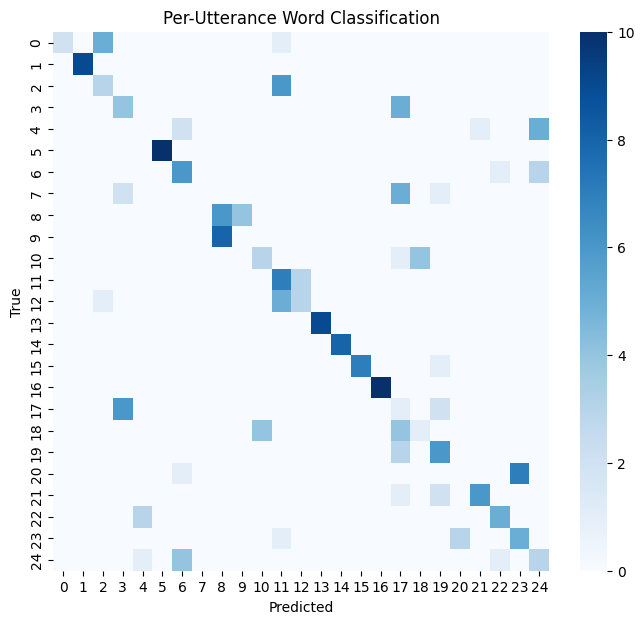

In [62]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,7))
sns.heatmap(cm, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Per-Utterance Word Classification")
plt.show()


In [63]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [64]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate(clf, X, y):
    accs = []
    for train_idx, test_idx in skf.split(X, y):
        clf.fit(X[train_idx], y[train_idx])
        pred = clf.predict(X[test_idx])
        accs.append(accuracy_score(y[test_idx], pred))
    return np.mean(accs), np.std(accs)


In [65]:
models = {
    "Linear SVM": SVC(kernel="linear"),
    "RBF SVM": SVC(kernel="rbf"),
    "LogReg": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=300)
}

for name, clf in models.items():
    mean_acc, std_acc = evaluate(clf, X_utt_std, y_word)
    print(f"{name:15s} | acc = {mean_acc:.3f} ± {std_acc:.3f}")


Linear SVM      | acc = 0.416 ± 0.053
RBF SVM         | acc = 0.254 ± 0.019
LogReg          | acc = 0.367 ± 0.057
RandomForest    | acc = 1.000 ± 0.000


In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", 0.01, 0.1, 1]
}

svm = SVC(kernel="rbf")
grid = GridSearchCV(
    svm,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_utt_std, y_word)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Best params: {'C': 100, 'gamma': 0.01}
Best CV accuracy: 0.4841414141414142


In [67]:
def speaker_held_out_eval(X, y_word, y_speaker, clf):
    accs = []
    for spk in np.unique(y_speaker):
        train_idx = y_speaker != spk
        test_idx = y_speaker == spk

        clf.fit(X[train_idx], y_word[train_idx])
        pred = clf.predict(X[test_idx])
        accs.append(accuracy_score(y_word[test_idx], pred))

    return np.mean(accs), np.std(accs)


In [68]:
clf = SVC(kernel="rbf", C=grid.best_params_["C"],
          gamma=grid.best_params_["gamma"])

mean_acc, std_acc = speaker_held_out_eval(
    X_utt_std, y_word, y_speaker, clf
)

print(f"Speaker-held-out accuracy: {mean_acc:.3f} ± {std_acc:.3f}")


Speaker-held-out accuracy: 0.534 ± 0.224
